In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix




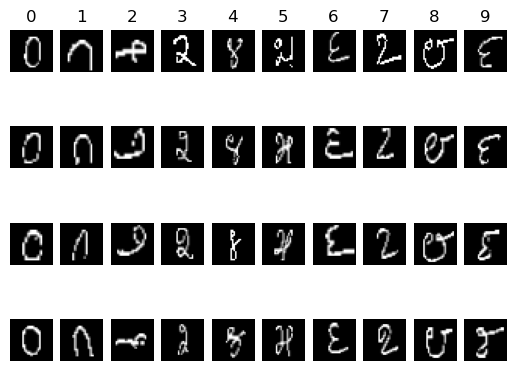

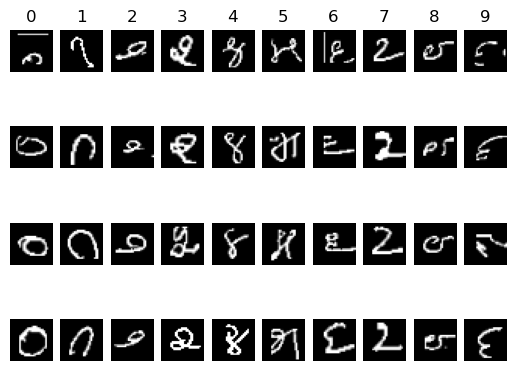

In [2]:
df_train = pd.read_csv("Data/train.csv");
df_test = pd.read_csv('Data/Dig-MNIST.csv');

def show_imgs(x_train, y_train, rows=3):
    classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    for y, cls in enumerate(classes):
        idxs = np.nonzero([i == y for i in y_train])
        idxs = np.random.choice(idxs[0], rows)
        for i , idx in enumerate(idxs):
            plt_idx = i * len(classes) + y + 1
            plt.subplot(rows, len(classes), plt_idx)
            plt.imshow(x_train.iloc[idx].values.reshape((28,28)), cmap='gray')
            plt.axis("off")
            if i == 0:
                plt.title(cls)
    plt.show()


show_imgs(df_train.iloc[:,1:], df_train.iloc[:,0], rows=4);
show_imgs(df_test.iloc[:,1:], df_test.iloc[:,0], rows=4);

In [3]:
def load_dataset(path):
    data = pd.read_csv(path, sep=',');
    x = data.iloc[:, 1:]; #features
    y = data.iloc[:, 0]; #classes
    return x, y;

def get_metrics(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train);
    y_pred = model.predict(x_test);
    y_pred_prob = model.predict_proba(x_test);

    accuracy = accuracy_score(y_test, y_pred);
    kappa = cohen_kappa_score(y_test, y_pred);
    conf_matrix = confusion_matrix(y_test, y_pred);

    # For multiclass, specify 'average' parameter
    precision = precision_score(y_test, y_pred, average='weighted');  # 'weighted'
    recall = recall_score(y_test, y_pred, average='weighted');        # 'weighted'
    f1 = f1_score(y_test, y_pred, average='weighted');                # 'weighted'

    # One-vs-Rest approach for multiclass ROC and AUC
    lb = LabelBinarizer();
    y_test_bin = lb.fit_transform(y_test);
    fpr, tpr, thresholds = {}, {}, {};
    auc = {};
    
    for i in range(y_test_bin.shape[1]):  # Iterate over each class
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]);
        auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i]);

    return accuracy, kappa, conf_matrix, precision, recall, f1, fpr, tpr, thresholds, auc;








In [14]:
data_x, data_y = load_dataset('Data/Dig-MNIST.csv');
data_x_test, data_y_test = load_dataset('Data/test.csv');
data_x_train, data_y_train = load_dataset('Data/train.csv');


# model = RandomForestClassifier(
#     n_estimators=500,
#     max_depth=20,
#     min_samples_split=5,
#     min_samples_leaf=2,
#     max_features='sqrt',
#     random_state=42
# );  #acc = 64%, kappa = 60%


# model = RandomForestClassifier(n_estimators=300, n_jobs=-2, random_state=42); #60% 58%

model = RandomForestClassifier(
    n_estimators=300, 
    n_jobs=-2,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    max_features='sqrt',
); #65% 61%

results = get_metrics(model, data_x_train, data_x, data_y_train, data_y);

accuracy, kappa, conf_matrix, precision, recall, f1, fpr, tpr, thresh, auc = results;
print(accuracy,kappa );

0.65205078125 0.6133897569444444


In [15]:
print("accuracy: " , accuracy);
print("kappa: " , kappa);
print("precision: " , precision);
print("recall: " , recall);
print("f1: " , f1);

accuracy:  0.65205078125
kappa:  0.6133897569444444
precision:  0.7061456088709445
recall:  0.65205078125
f1:  0.6495629380963749


<Figure size 800x600 with 0 Axes>

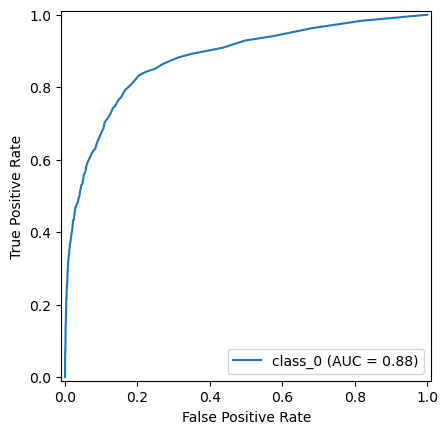

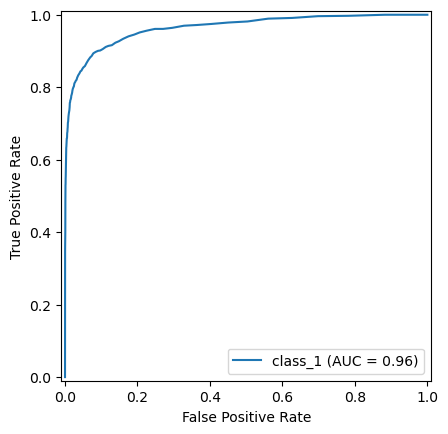

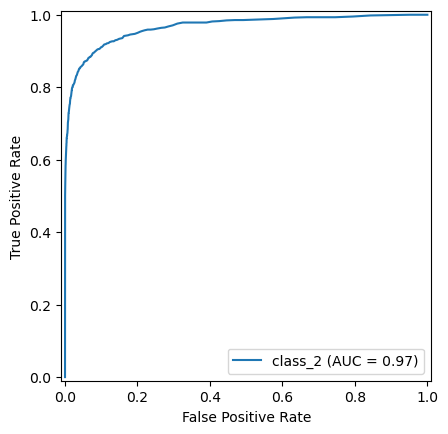

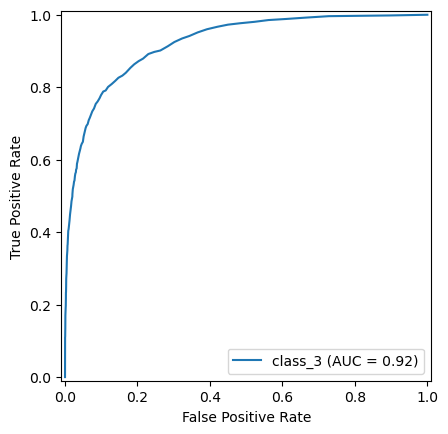

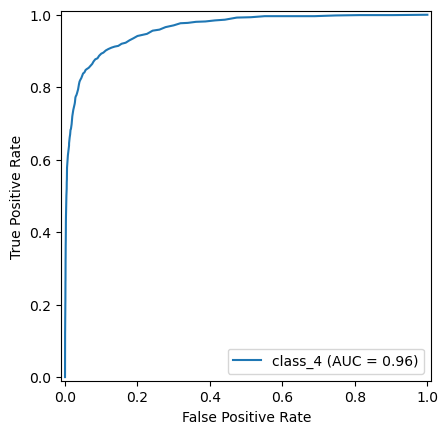

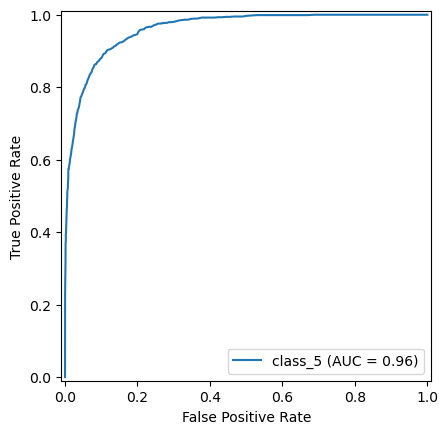

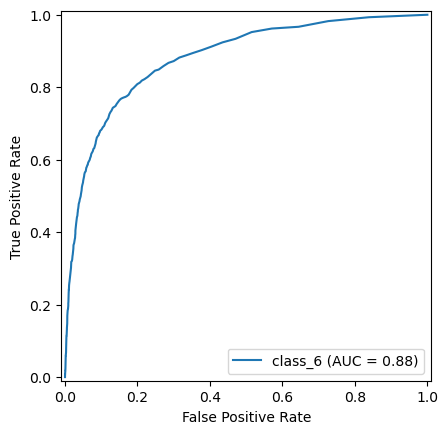

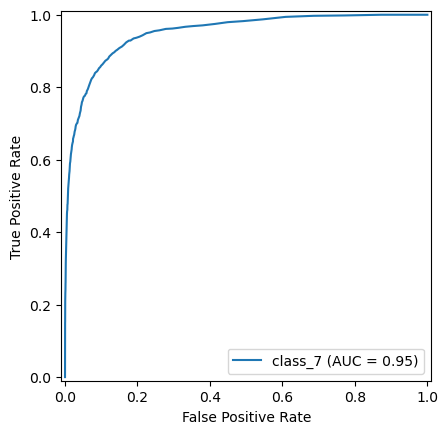

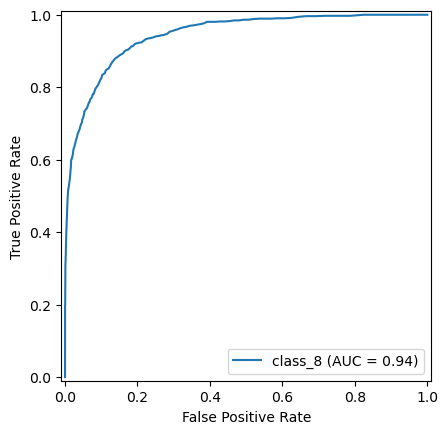

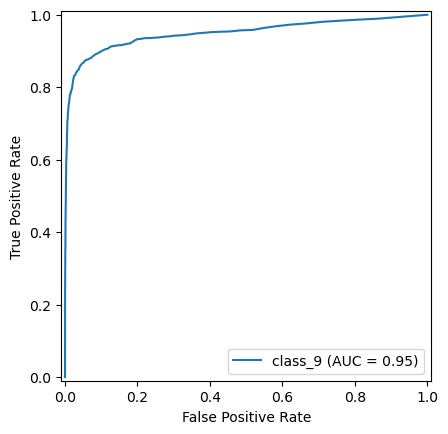

In [16]:
# Plot ROC curves for each class
plt.figure(figsize=(8, 6));  # Set the figure size

for i in range(len(fpr)):  # Iterate over each class
    display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=auc[i], estimator_name=f'class_{i}');
    display.plot();  # Plot the ROC curve


plt.show();


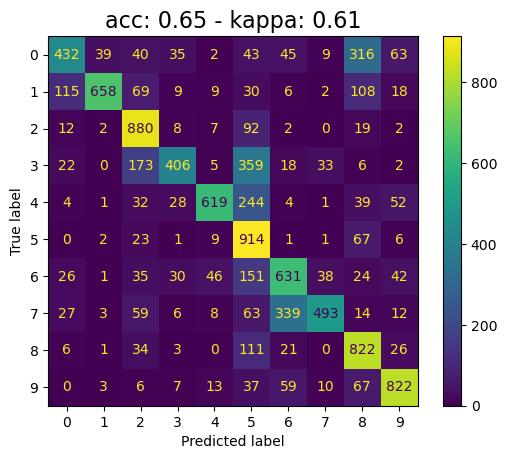

In [17]:
display = ConfusionMatrixDisplay(conf_matrix)
display.plot()

# Set the title for the confusion matrix
plt.title(f'acc: {accuracy:.2f} - kappa: {kappa:.2f}', fontsize=16)

# Show the plot
plt.show()

In [20]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [3, 5, 7],
};
model = RandomForestClassifier();

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy');
grid_search.fit(data_x_train, data_y_train);

# Get the best model
best_model = grid_search.best_estimator_;

# Make predictions on the test data
pred = best_model.predict(data_x);


In [21]:
# Get the true values (data_y)
true = data_y;

# Now, you have the predictions (pred) and true values (true)
# You can calculate accuracy, confusion matrix, etc.
data_grid_accuracy = accuracy_score(true, pred);
data_grid_matrix = confusion_matrix(true, pred);

# Optionally, print the results
print(f"Accuracy: {data_grid_accuracy}");
print(f"Confusion Matrix:\n{data_grid_matrix}");

Accuracy: 0.6314453125
Confusion Matrix:
[[398  31  39  37   3  36  53   3 370  54]
 [ 99 650  67   8   8  37   6   2 130  17]
 [ 12   2 884  11   6  82   1   0  20   6]
 [ 22   1 124 334   4 470  27  35   4   3]
 [  5   0  35  20 557 242   4   1  96  64]
 [  0   1  20   1   7 912   1   2  72   8]
 [ 18   3  39  21  58 139 637  54  22  33]
 [ 22   3  56  11   6  61 411 428  17   9]
 [  6   0  44   2   1  55  24   1 870  21]
 [  1   2   5   5  13  30  61  11 100 796]]


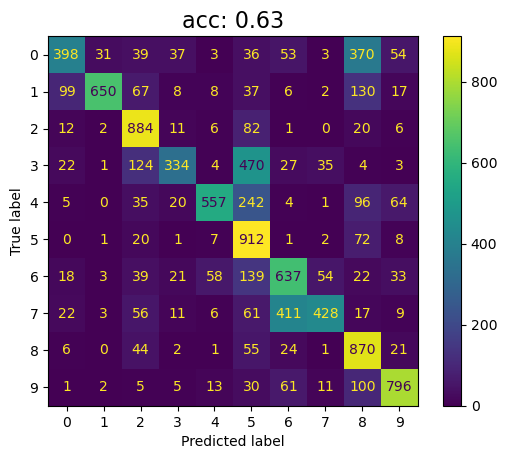

In [22]:
display = ConfusionMatrixDisplay(confusion_matrix=data_grid_matrix);
display.plot();

plt.title(f'acc: {data_grid_accuracy:.2f}', fontsize=16);
plt.show();
